<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/main/template-report-Navier-Stokes-ALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations - ALE**
**Johan Hoffman**

# **Abstract**

This report studies how the drag and lift forces acting on a circular hole are affected when the mesh is deformed in different ways.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

In this report, the effect on a circular hole in a domain is studied when the mesh is deformed. We look at an ALE finite element method, where ALE stands for abitrary Lagrarian-Eulerian-method. These methods are often used to model fluid-structure interaction.(Lecture 5)

We simulate the flow using the Navier-Stokes equation  $$\dot u + (u\cdot \nabla)u + \nabla p - \nu\Delta u = f,\\ \nabla \cdot u=0,
$$
and look at how the lift and drag forces act on the circular hole in the domain when the mesh is deformed according to a mesh displacement function.

# **Method**
First, we observe how the forces in the x- and y-direction on the circular hole are affected by the mesh deformation that makes the hole deform and move up and down. We find the drag force by setting

```
phi_x = 1.0
phi_y = 0.0

```
and the lift force by setting

```
phi_x = 0.0
phi_y = 1.0

```
Then, we want to look at the forces acting on the hole when the circular hole is only deformed, but not moving up and down. This is done by changing the expression


```
w = Expression(("amp_x*(-rc)*sin(2.0*pi*t*freq)*sin(pi*(x[0]-xc)/L)","-rc* amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*(x[1]-yc)/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, rc=rc,yc=yc,xc=xc,element = V.ufl_element())

```
 which determines how the mesh changes between the timesteps. This is then applied to the mesh by using the function



```
ALE.move(mesh, w)
```




**Define domain and mesh**

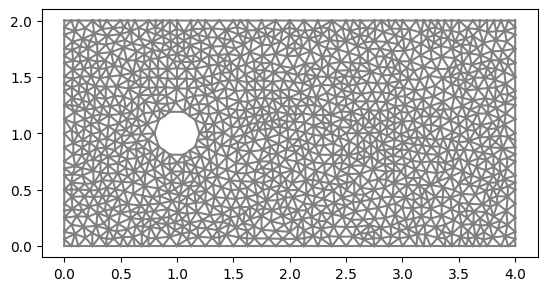

In [ ]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**
Below, the mesh at regular time intervals during the simulation is shown in Figure 1. We can see that the circular hole occilates and deforms as it moves.

![picture](http://drive.google.com/uc?export=view&id=1G_MngMThhhJfgSxMoBSH4H_ZfGvlTlxM)

***Fig 1: Mesh deformation for occillating circle at tifferent timesteps***

In Figure 2, we can see the drag and lift forces on the cylinder. The peaks of the lift force corresponds with the occilating movement, whereas the drag force is affected by how deformed the circle is.

![picture](http://drive.google.com/uc?export=view&id=15Z4ScKna1a8jcW7zVPo8zbVWi6xO4Hcx)

***Fig 2: Drag force (left) and lift force (right) on the occillating circle***

In figure 3, the mesh deformation for a circle that does not move up and down is shown.

![picture](http://drive.google.com/uc?export=view&id=16NHzxxRFKRLbOrPHu019UqB_XQuJR8BM)

***Fig 3: Mesh deformation for non-occillating circle at tifferent timesteps***

In Figure 4, we again see the drag and lift forces on the circle. The lift force is smaller, and occilates quicker than in the previous case. We can also se that the drag force is about the same size.

![picture](http://drive.google.com/uc?export=view&id=15bGhrNaHHbpSAa3TH4xP8SruXxUI-dAT)

***Fig 4: Drag force (left) and lift force (right) on the non-occillating circle***


**Define flow parameters**

In [ ]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Define mesh deformation w, mesh velocity = w/dt
amp_x = 0.0
amp_y = 1.0e-2

#amp_y = 2
freq = 0.1
t = 0.0

#w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())
w = Expression(("amp_x*(-rc)*sin(2.0*pi*t*freq)*sin(pi*(x[0]-xc)/L)","-rc* amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*(x[1]-yc)/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, rc=rc,yc=yc,xc=xc,element = V.ufl_element())

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 20

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.03285506167650246


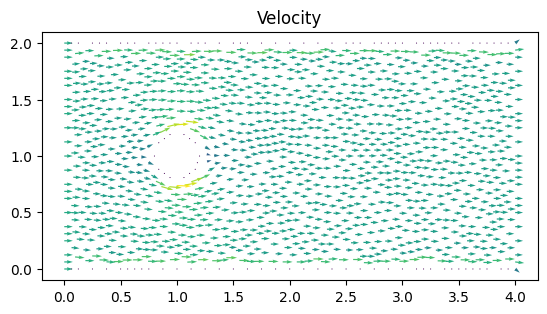

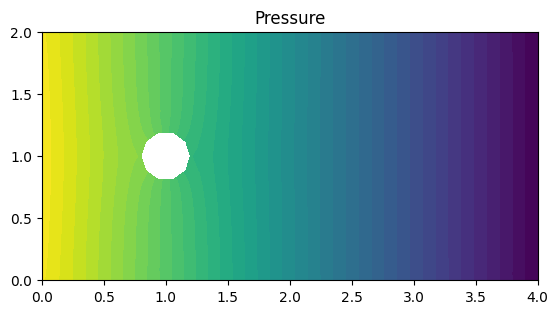

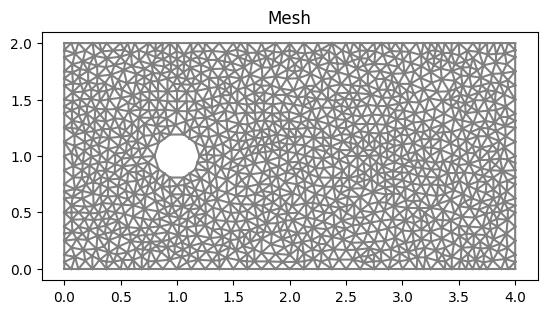

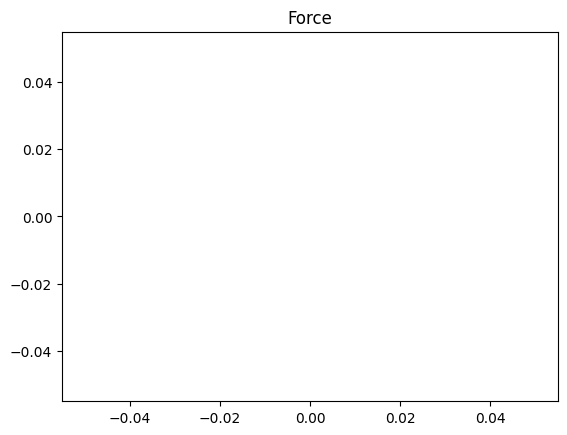

Time t = 1.5113328371191124


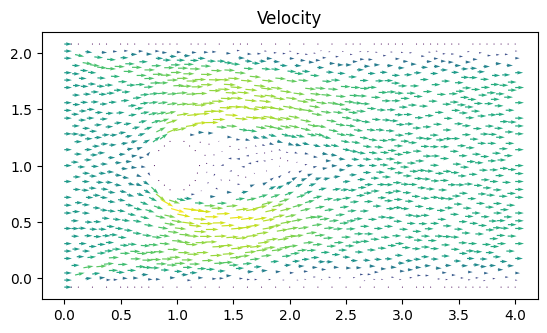

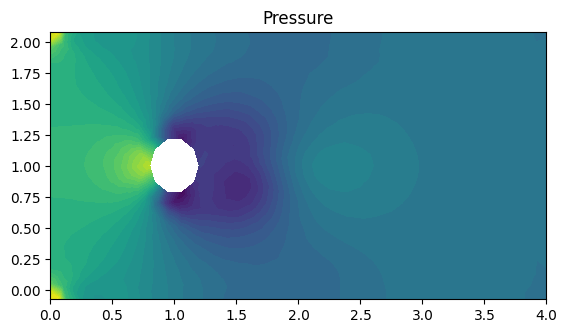

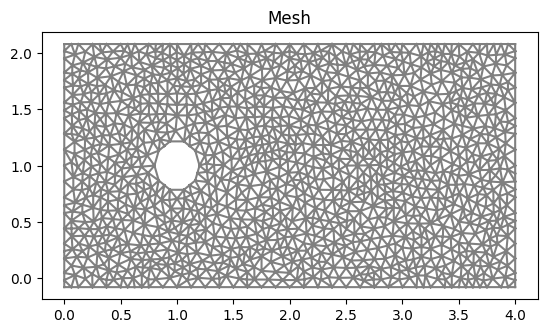

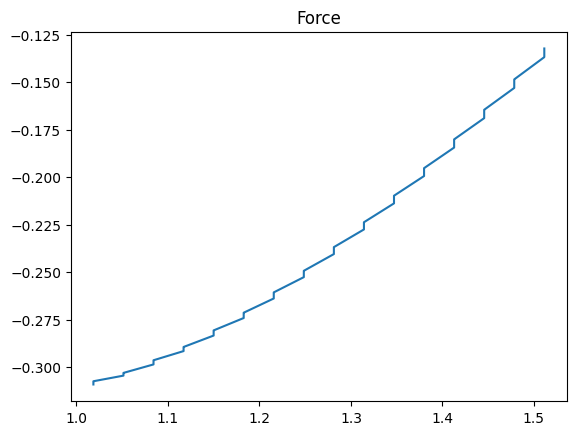

Time t = 3.022665674238231


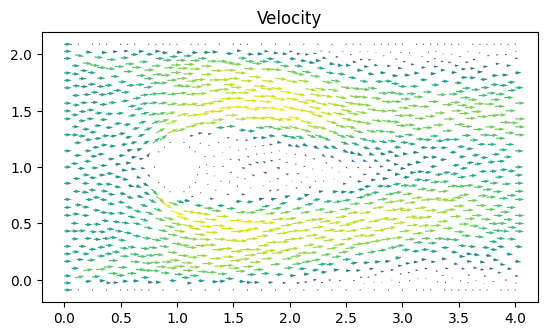

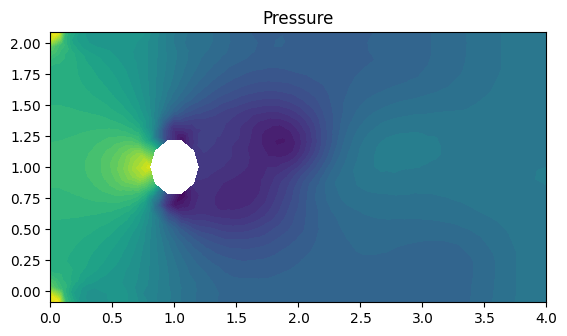

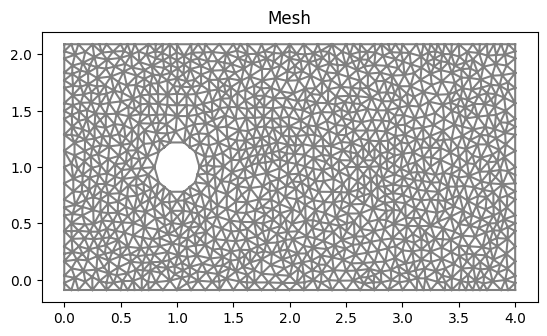

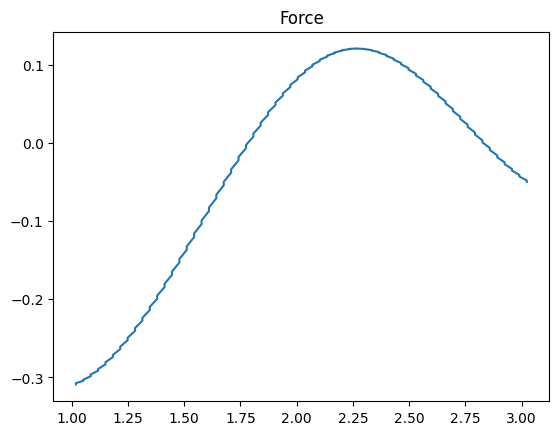

KeyboardInterrupt: 

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt

while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    w.t = t
    ALE.move(mesh, w)

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plt.figure()
        plot(mesh, title="Mesh")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

In this report, the deformation of a mesh under different functions has been studied. The changes in drag and lift forces were observed and compared between two different cases.